# Slim-SOENs Overview

In [1]:
# General imports
import numpy as np
import matplotlib.pyplot as plt

# Add source directory to path 
# (may depend on machine specific directory organization)
import sys
sys.path.append('../slim_soens')

# Import necessary slim-soens tools
from neuron import Neuron
from network import Network
from plotting import *
from system_functions import *

## At A Glance
### The Simplest Neuron
 - The below code will generate a 'point' neuron (one soma, one synapse)
 - The `Neuron` class can be used to construct arbitrary morphologies

In [2]:
sample_neuron = Neuron(
    name = "sample_neuron", # key-word arguments can be used to define neuron param
    threshold = 0.5         # for example, this will define spiking threshold of soma
)
sample_neuron.parameter_print() # a way to check work (don't worry about this for now)

Neuron sample_neuron parameters:
   0 id                    0
   1 name                  sample_neuron
   2 weights               [[[]]]
   3 arbor_params          [[[]]]
   4 synaptic_strength     1
   5 no_synapses           False
   6 threshold             0.5
   7 dendrite_list         [<components.Soma object at 0x000002C3DF325C30>, <components.Refractory object at 0x000002C3DF45F730>]
   8 dend_soma             <components.Soma object at 0x000002C3DF325C30>
   9 dend_ref              <components.Refractory object at 0x000002C3DF45F730>
   10 arbor_adjacency       [[ 0.    0.  ]
 [-0.85  0.  ]]
   11 synapse_list          [<components.Synapse object at 0x000002C3DF45F100>]
   12 dims                  [2, 0]
   13 layers                2


### Input and Running

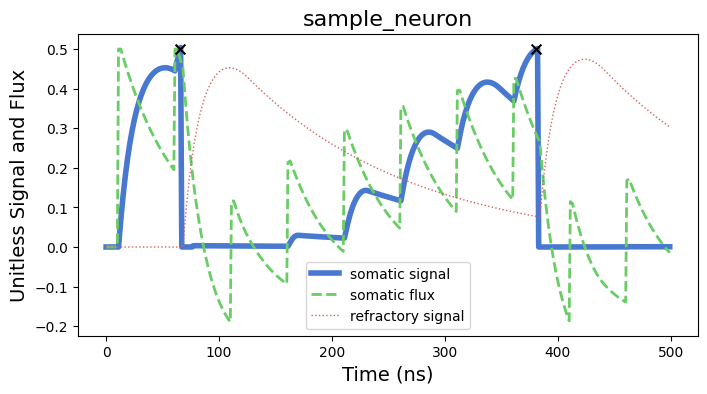

In [3]:
# Input can take the from of an np.array of spike-times
duration = 500
in_spikes = np.arange(10,duration,50)

# This can be added to all available synapses
sample_neuron.add_uniform_input(in_spikes)

# slim-soens simulates networks, even if on of one neuron
sample_net = Network(
    run_simulation = True,              # network can be run automatically upon creation
    nodes          = [sample_neuron],   # there could be many interconnected nodes in this list
    duration       = duration,          #  How long to simulate (in nanoseconds)
)

plot_nodes([sample_neuron]) # plot

sample_net.clear_net() # clear net (for re-use)

### Dendritic Arbors
 - SOEN systems prefer limited fan-in
 - Therefore benefit from dendritc arbors to faciliate greater number of incoming connections

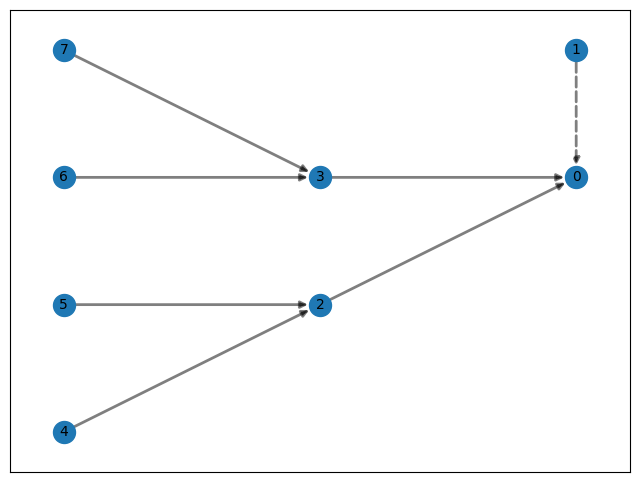

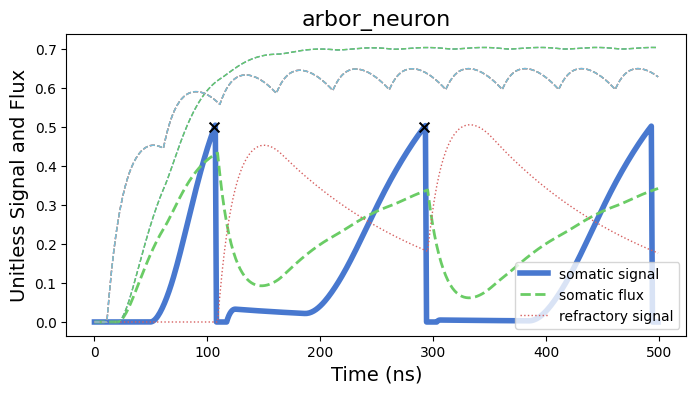

In [4]:
# Here, the weights argument defines the dendritic structure
arbor_neuron = Neuron(
    name = "arbor_neuron",
    weights = [
        [[0.2,0.5]],
        [[0.4,0.3],[0.1,0.6]]
        ]
)

# Plot structure with networkx
arbor_neuron.plot_structure()

# Add input (uniformly to all synapses)
duration = 500
in_spikes = np.arange(10,duration,50)
arbor_neuron.add_uniform_input(in_spikes)

# Create and run network
arbor_net = Network(
    run_simulation = True,
    nodes          = [arbor_neuron],
    duration       = duration,
)

plot_nodes(arbor_net.nodes,dendrites = True)
arbor_net.clear_net()

[[0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]]


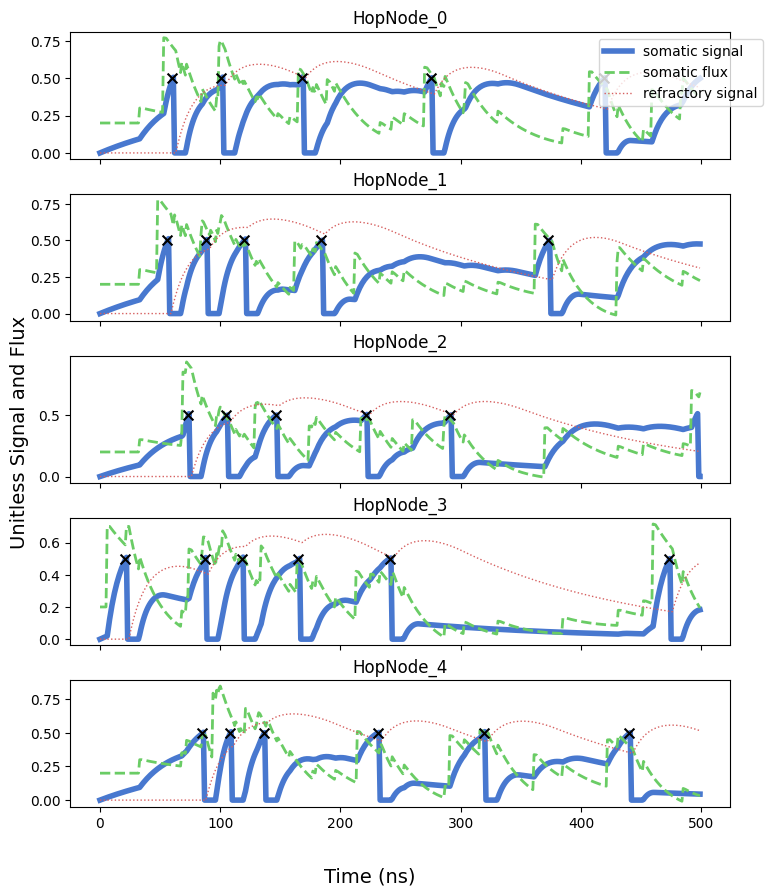

In [8]:
from network import HopfieldNetwork
N = 5
hop = HopfieldNetwork(
    N                    = N,   # number of neurons in network
    connection_strengths = 1/N, # connection strength between neurons
    global_offset        = .2   # global flux offset for all somas (can array over time)
    )
print(hop.network_adjacency)
for i,node in enumerate(hop.nodes):
    rand_spikes = np.random.rand(10)*duration
    rand_spikes.sort()
    node.synapse_list[0].spike_times = rand_spikes
hop.run_network_simulation(duration=500)
plot_nodes(hop.nodes)

### Hopfield Networks

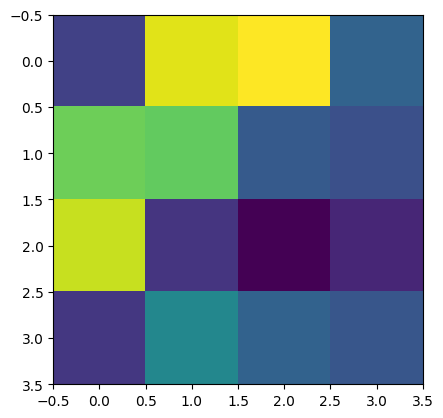

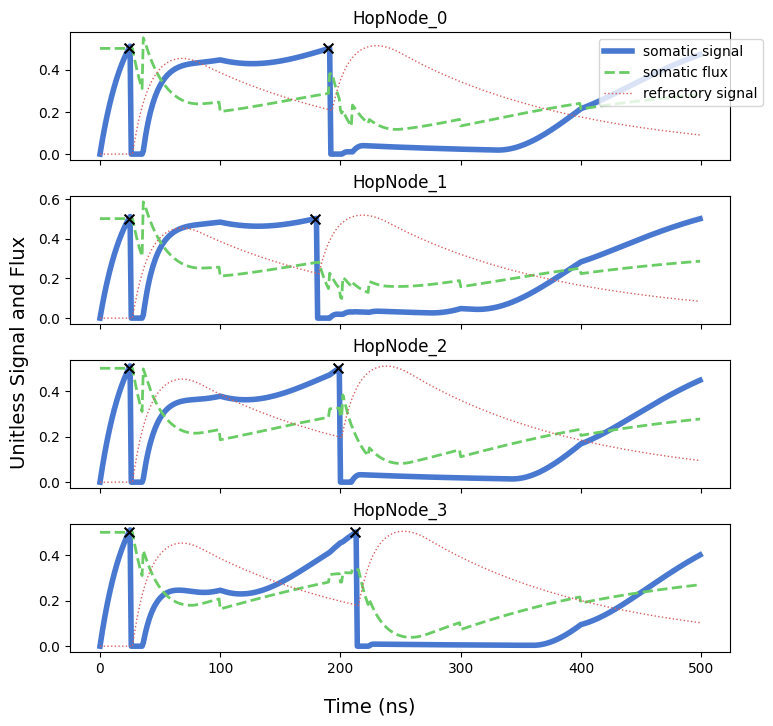

In [6]:
N = 4
adjacency = np.random.rand(N,N)/N
anneal_phases = 5
duration = 500
steady_decay = False
plt.imshow(adjacency)
plt.show()

# adjacency-defined hopfield network
hop = HopfieldNetwork(network_adjacency=adjacency)

# add specified input (when .flux_offset is an array)
for i,node in enumerate(hop.nodes):

    # steadily decaying input
    if steady_decay == True:
        node.dend_soma.flux_offset = [(.5/(1+.0075*t)) for t in range(duration)]

    # decay in phases
    else:
        node.dend_soma.flux_offset = np.concatenate(
            [np.ones(int(duration/anneal_phases))*(.5/(1+.1*ap)) 
             for ap in range(anneal_phases)]
        )


hop.run_network_simulation(duration=duration)
plot_nodes(hop.nodes)

## Input Methods

## Plotting Tools

## Components

## Supervised Learning

## Backends

## Demo